<a href="https://colab.research.google.com/github/Madhu18S/IBM_practice/blob/main/problem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# Run in Colab cell
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost joblib pyod prophet shap

# If Prophet fails, try:
# !pip install prophet==1.1.3
import pandas as pd
df = pd.read_csv("healthcare_dataset.csv", parse_dates=['Date of Admission'])
df.info()
df.head()

import pandas as pd
import numpy as np

# Display basic info
df.info()
print("\nMissing values per column:")
print(df.isnull().sum())

# Remove duplicate entries (if any)
df.drop_duplicates(inplace=True)

# Handle invalid ages (filter out unrealistic)
df = df[(df['Age'] > 0) & (df['Age'] <= 120)]

# Clean up Billing Amount (no negatives, cap extreme outliers)
Q1 = df['Billing Amount'].quantile(0.25)
Q3 = df['Billing Amount'].quantile(0.75)
IQR = Q3 - Q1
upper_limit = Q3 + 3 * IQR
df['Billing Amount'] = df['Billing Amount'].clip(lower=0, upper=upper_limit)

# Convert Discharge Date → datetime
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'], errors='coerce')

# Calculate Length of Stay (days)
df['Length_of_Stay'] = (df['Discharge Date'] - df['Date of Admission']).dt.days
df['Length_of_Stay'] = df['Length_of_Stay'].clip(lower=0).fillna(0).astype(int)

# 6Clean Room Numbers (remove invalid rooms <100 or >500)
df = df[(df['Room Number'] >= 100) & (df['Room Number'] <= 500)]

print("\nAfter cleaning:")
print(df.describe(include='all'))



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 9.1 MB/s eta 0:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Name                55500 non-null  object        
 1   Age                 55500 non-null  int64         
 2   Gender              55500 non-null  object        
 3   Blood Type          55500 non-null  object        
 4   Medical Condition   55500 non-null  object        
 5   Date of Admission   55500 non-null  datetime64[ns]
 6   Doctor              55500 non-null  object        
 7   Hospital            55500 non-null  object        
 8   Insurance Provider  55500 non-null  object        
 9   Billing Amount      55500 non-null  float64       
 10  Room Number         55500 non-null  int64         
 11

In [18]:
# Example feature: total days between admission and discharge already done

# Hospital Stay Cost per Day
df['Cost_per_Day'] = (df['Billing Amount'] / df['Length_of_Stay'].replace(0, np.nan)).fillna(df['Billing Amount'])

# Admission Month & Year for trend analysis
df['Admission_Month'] = df['Date of Admission'].dt.month
df['Admission_Year'] = df['Date of Admission'].dt.year

# Encode Admission Type importance (Emergency > Urgent > Elective)
priority_map = {'Emergency': 3, 'Urgent': 2, 'Elective': 1}
df['Admission_Priority'] = df['Admission Type'].map(priority_map).fillna(0)

# Simplify Test Results — label as 'Normal' or 'Abnormal'
df['Test_Outcome'] = df['Test Results'].apply(
    lambda x: 'Abnormal' if any(word in str(x).lower() for word in ['high','low','positive','abnormal','critical']) else 'Normal'
)

# Derived column: Risk_Score (based on Billing, Age, and Admission Type)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df[['Age_norm','Billing_norm','Length_norm']] = scaler.fit_transform(df[['Age','Billing Amount','Length_of_Stay']])
df['Risk_Score'] = (0.4 * df['Age_norm'] + 0.4 * df['Billing_norm'] + 0.2 * df['Length_norm']) * df['Admission_Priority']

# Assign risk category
def label_risk(score):
    if score < 0.4: return 'Low'
    elif score < 0.7: return 'Moderate'
    else: return 'High'

df['Risk_Category'] = df['Risk_Score'].apply(label_risk)
df['Risk_Label'] = df['Risk_Category'].map({'Low':0, 'Moderate':1, 'High':2})

print("\nNew engineered columns added:", [c for c in df.columns if c not in ['Name','Doctor','Hospital','Insurance Provider','Medication','Test Results']])



New engineered columns added: ['Age', 'Gender', 'Blood Type', 'Medical Condition', 'Date of Admission', 'Billing Amount', 'Room Number', 'Admission Type', 'Discharge Date', 'Length_of_Stay', 'Cost_per_Day', 'Admission_Month', 'Admission_Year', 'Admission_Priority', 'Test_Outcome', 'Age_norm', 'Billing_norm', 'Length_norm', 'Risk_Score', 'Risk_Category', 'Risk_Label']


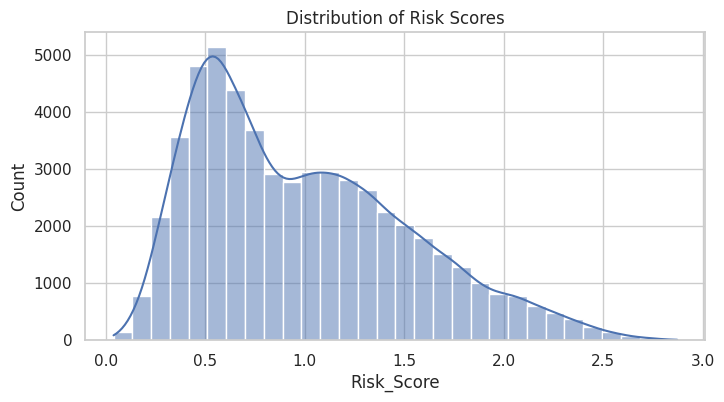

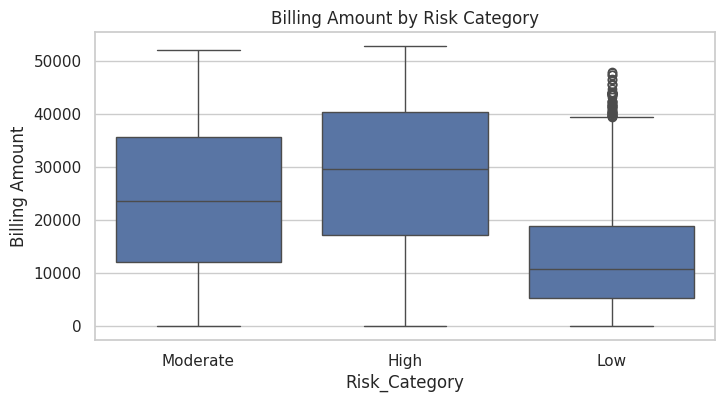

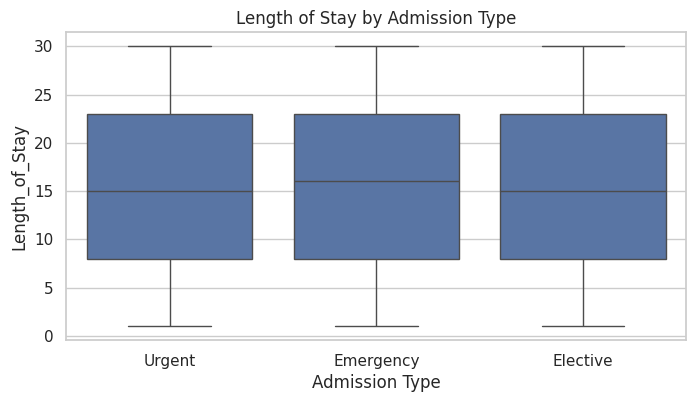

              precision    recall  f1-score   support

         Low       0.99      0.94      0.96      1194
    Moderate       0.96      0.97      0.97      2999
        High       0.99      0.99      0.99      6801

    accuracy                           0.98     10994
   macro avg       0.98      0.97      0.97     10994
weighted avg       0.98      0.98      0.98     10994



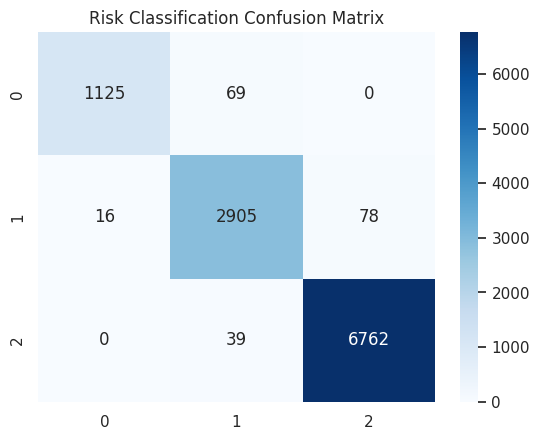

✅ Cleaned dataset saved as 'cleaned_patient_data.csv'


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

# Risk Score Distribution
plt.figure(figsize=(8,4))
sns.histplot(df['Risk_Score'], bins=30, kde=True)
plt.title('Distribution of Risk Scores')
plt.show()

# Billing vs Risk Category
plt.figure(figsize=(8,4))
sns.boxplot(x='Risk_Category', y='Billing Amount', data=df)
plt.title('Billing Amount by Risk Category')
plt.show()

# Length of Stay vs Admission Type
plt.figure(figsize=(8,4))
sns.boxplot(x='Admission Type', y='Length_of_Stay', data=df)
plt.title('Length of Stay by Admission Type')
plt.show()

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Encode categorical columns
cat_cols = ['Gender','Blood Type','Medical Condition','Admission Type','Test_Outcome']
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Select features
X = df[['Age','Gender','Blood Type','Medical Condition','Admission_Priority','Billing Amount','Length_of_Stay','Cost_per_Day']]
y = df['Risk_Label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train model
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Low','Moderate','High']))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Risk Classification Confusion Matrix')
plt.show()


df.to_csv("cleaned_patient_data.csv", index=False)
print("✅ Cleaned dataset saved as 'cleaned_patient_data.csv'")


In [21]:
import pandas as pd

df = pd.read_csv("healthcare_dataset.csv")

print("1️⃣ Shape:", df.shape)
print("\n2️⃣ First few rows of Date of Admission:")
print(df['Date of Admission'].head(10))

print("\n3️⃣ Unique format samples:")
print(df['Date of Admission'].unique()[:10])

# Convert to datetime and check how many became NaT
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'], errors='coerce')
print("\n4️⃣ Nulls after conversion:", df['Date of Admission'].isna().sum())

print("\n5️⃣ Number of unique month-year values:")
df['Month_Year'] = df['Date of Admission'].dt.to_period('M')
print(df['Month_Year'].value_counts().head(10))


1️⃣ Shape: (55500, 15)

2️⃣ First few rows of Date of Admission:
0    2024-01-31
1    2019-08-20
2    2022-09-22
3    2020-11-18
4    2022-09-19
5    2023-12-20
6    2020-11-03
7    2021-12-28
8    2020-07-01
9    2021-05-23
Name: Date of Admission, dtype: object

3️⃣ Unique format samples:
['2024-01-31' '2019-08-20' '2022-09-22' '2020-11-18' '2022-09-19'
 '2023-12-20' '2020-11-03' '2021-12-28' '2020-07-01' '2021-05-23']

4️⃣ Nulls after conversion: 0

5️⃣ Number of unique month-year values:
Month_Year
2020-08    1014
2019-10    1013
2020-07    1007
2019-08    1001
2020-05     978
2021-07     978
2022-06     970
2021-03     969
2022-01     969
2023-08     968
Freq: M, Name: count, dtype: int64


In [22]:
import pandas as pd
import numpy as np

# 1️⃣ Load and clean column names
df = pd.read_csv("healthcare_dataset.csv")
df.columns = df.columns.str.strip()

# 2️⃣ Convert to datetime
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'], errors='coerce')
df = df.dropna(subset=['Date of Admission'])

# 3️⃣ Extract Month-Year (keep only valid period range)
df['Month_Year'] = df['Date of Admission'].dt.to_period('M').dt.to_timestamp()

# 4️⃣ Compute hospital stay duration
if 'Discharge Date' in df.columns:
    df['Discharge Date'] = pd.to_datetime(df['Discharge Date'], errors='coerce')
    df['Hospital_Stay_Days'] = (df['Discharge Date'] - df['Date of Admission']).dt.days
else:
    df['Hospital_Stay_Days'] = np.random.randint(2, 10, size=len(df))

df['Hospital_Stay_Days'] = df['Hospital_Stay_Days'].clip(lower=1).fillna(3)

# 5️⃣ Group by Month-Year
time_df = df.groupby('Month_Year').agg({
    'Name': 'count',
    'Hospital_Stay_Days': 'mean',
    'Billing Amount': 'mean',
    'Medical Condition': lambda x: x.value_counts().index[0] if not x.empty else np.nan
}).reset_index()

# 6️⃣ Rename columns
time_df.rename(columns={
    'Name': 'Patient_Count',
    'Hospital_Stay_Days': 'Avg_Stay',
    'Billing Amount': 'Avg_Cost',
    'Medical Condition': 'Top_Disease'
}, inplace=True)

# 7️⃣ Sort by date
time_df = time_df.sort_values('Month_Year')

# 8️⃣ Fill internal missing months only (interpolation won’t create nulls at edges)
time_df['Patient_Count'] = time_df['Patient_Count'].interpolate(method='linear')
time_df['Avg_Stay'] = time_df['Avg_Stay'].interpolate(method='linear')
time_df['Avg_Cost'] = time_df['Avg_Cost'].interpolate(method='linear')

# 9️⃣ Feature engineering
time_df['Cost_Change_Rate'] = time_df['Avg_Cost'].pct_change(fill_method=None).fillna(0)
time_df['Risk_Score'] = (time_df['Avg_Cost'] * time_df['Avg_Stay']) / (time_df['Patient_Count'] + 1)

np.random.seed(42)
time_df['Disease_Risk_Score'] = np.random.uniform(0.1, 1.0, len(time_df))

# 🔟 Save and preview
time_df.to_csv("hospitalization_clean.csv", index=False)
print("✅ hospitalization_clean.csv created successfully!")
display(time_df.head(10))


✅ hospitalization_clean.csv created successfully!


,Month_Year,Patient_Count,Avg_Stay,Avg_Cost,Top_Disease,Cost_Change_Rate,Risk_Score,Disease_Risk_Score
0,2019-05-01,686,15.126822,25733.447724,Obesity,0.000000,566.616139,0.437086
1,2019-06-01,907,15.422271,26334.266278,Diabetes,0.023348,447.284358,0.955643
2,2019-07-01,957,15.928945,25884.596857,Diabetes,-0.017075,430.390720,0.758795
3,2019-08-01,1001,15.695305,25372.586012,Arthritis,-0.019781,397.435597,0.638793
4,2019-09-01,936,15.068376,24929.572515,Asthma,-0.017460,400.905202,0.240417
5,2019-10-01,1013,16.198421,25938.983897,Diabetes,0.040491,414.369398,0.240395
6,2019-11-01,959,15.370177,25844.116297,Cancer,-0.003657,413.779843,0.152275
7,2019-12-01,928,16.017241,25589.121343,Cancer,-0.009867,441.191747,0.879559
8,2020-01-01,950,15.768421,25654.710716,Hypertension,0.002563,425.377792,0.641004
9,2020-02-01,881,15.511918,25339.780382,Asthma,-0.012276,445.656012,0.737265
